In [152]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [144]:
def get_variable(x):
    x = Variable(x)
    return x.cuda() if torch.cuda.is_available() else x

In [145]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5,],std=[0.5,])])

data_train=datasets.MNIST(root='data/',transform=transform,train=True,download=True)
data_test=datasets.MNIST(root='data/',transform=transform,train=False)

In [146]:
# shuffle = True to choose picture randomly
data_loader_train=torch.utils.data.DataLoader(dataset=data_train,batch_size=64,shuffle=True)
data_loader_test = torch.utils.data.DataLoader(dataset =data_test,batch_size = 64,shuffle = True)
    

[tensor(9), tensor(6), tensor(3), tensor(5), tensor(5), tensor(5), tensor(0), tensor(6), tensor(1), tensor(2), tensor(2), tensor(6), tensor(4), tensor(1), tensor(9), tensor(4)]


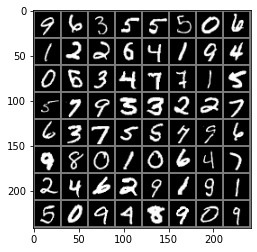

In [147]:
images,labels=next(iter(data_loader_train))
# Splicing the 64 pictures into one picture

img=torchvision.utils.make_grid(images)

# transpose the img because imshow need a img construction of (height,weight,channel) 
# but img has a construction of (channel,height,weight)

img=img.numpy().transpose(1,2,0)

# do a linear transformation 
# Grayscale stretch to increase contrast
std=[0.5,0.5,0.5]
mean=[0.5,0.5,0.5]
img=img*std+mean
print([labels[i] for i in range(16)])

plt.imshow(img)
plt.show()


In [148]:
'''
class CNN_Net(torch.nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=1,kernel_size=3))
        self.conv2=torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=1, kernel_size=3))
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(3200, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(1024, 10))
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        print(x2.shape)
        x = x2.view(-1,20*20*128)
        x = self.dense(x)
        return x
'''

class CNN_Net(torch.nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=2,kernel_size=2))
        self.conv2=torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=2, kernel_size=2))
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(7 * 7 * 128, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(1024, 10))

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x = x2.view(-1, 7 * 7 * 128)
        x = self.dense(x)
        return x


In [149]:
cnn = CNN_Net()
if torch.cuda.is_available():
    cnn = cnn.cuda()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(),lr=0.001)
def train():
    for data in data_loader_train:
        x_train, y_train = data
        x_train, y_train = get_variable(x_train),get_variable(y_train)
        y_hat = cnn(x_train)
        loss = loss_func(y_hat, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch %d, loss %.4f' % (epoch + 1, loss))
    return loss  

In [162]:
def test():
    correct = 0
    for data in data_loader_test:
        x_test, y_test = data
        x_test, y_test = get_variable(x_test), get_variable(y_test)
        outputs = cnn(x_test)
        _, predict = torch.max(outputs.data, dim=1)
        correct += torch.sum(predict == y_test.data)
    correct = correct.detach().cpu().numpy()
    print("correct rate = ",100 * correct/len(data_test))
    return 100 * correct/len(data_test) *0.01

epoch 1, loss 0.0007
correct rate =  99.01
epoch 2, loss 0.0000
correct rate =  99.21
epoch 3, loss 0.0001
correct rate =  99.2
epoch 4, loss 0.0001
correct rate =  99.17
epoch 5, loss 0.0000
correct rate =  99.2


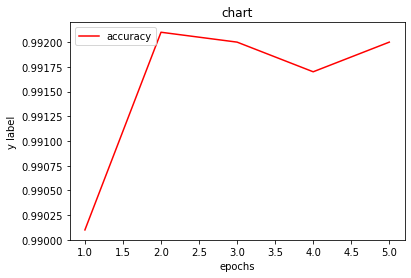

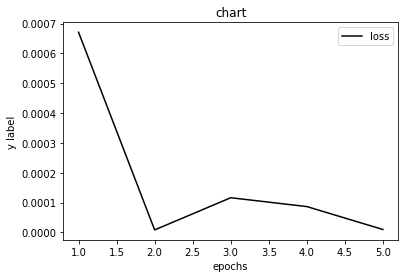

In [163]:
lss = []
acc = []
epochs = []
for epoch in range(5):
    epochs.append(epoch+1)
    ls = train();
    ac = test();
    l_tmp = ls.detach().cpu().numpy()
    lss.append(l_tmp)
    acc.append(ac);
    
plt.plot(epochs,acc,color='r',label='accuracy')  
plt.xlabel('epochs')    
plt.ylabel('y label')   
plt.title("chart")      
plt.legend()   
plt.show()

plt.plot(epochs,lss,color=(0,0,0),label='loss')
plt.xlabel('epochs')    
plt.ylabel('y label')   
plt.title("chart")      
plt.legend()            
plt.show()